<a href="https://colab.research.google.com/github/kojiyam/denso/blob/master/modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-commpy

     |████████████████████████████████| 51kB 1.8MB/s 


In [ ]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import IPython.display

from commpy.filters import rrcosfilter

In [ ]:
N = 10  # Number of symbols
Ts = 1 # s/symbol
sampling_rate = 10000 # 音として出力するため

In [ ]:
sB = np.random.randint(0, 4, N) # [0,3] (2 bit) の一様乱数をN個
sQ = np.exp(1j * (1/4 + sB/2) * np.pi) # QPSK

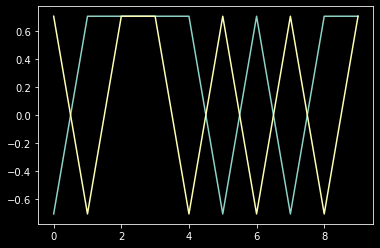

In [ ]:
plt.plot(sQ.real)
plt.plot(sQ.imag)
plt.show()

In [ ]:
# Rectangular pulse filter
# b = np.repeat(sQ,Ts*Fs)

In [ ]:
# sQ[0], 0, ..., 0, sQ[1], 0, ..., 0, sQ[2] という系列
b = np.ravel( np.concatenate([np.reshape(sQ,(N,1)), 
                              np.zeros([N,sampling_rate*Ts-1]) ], axis=1) )
#    ])

In [ ]:
#b = np.empty(0)
#for i in range(N):
#   b = np.concatenate([b, np.atleast_1d(sQ[i]), np.zeros(sampling_rate*Ts-1)])

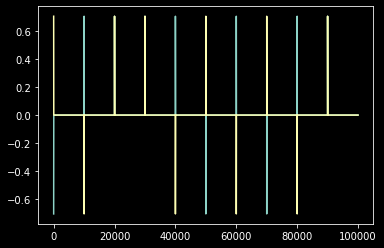

In [ ]:
plt.plot(b.real)
plt.plot(b.imag)

In [ ]:
sPSF = rrcosfilter(Ts*sampling_rate*6, 0.8, Ts, sampling_rate)[1]

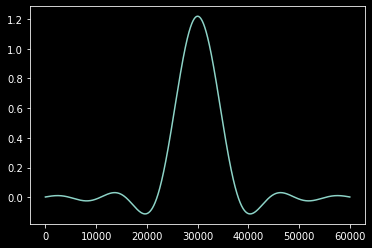

In [ ]:
plt.plot(sPSF)

In [ ]:
# ベースバンド信号
qW = np.convolve(sPSF, b) # Waveform with PSF
t = np.arange(qW.size)/sampling_rate

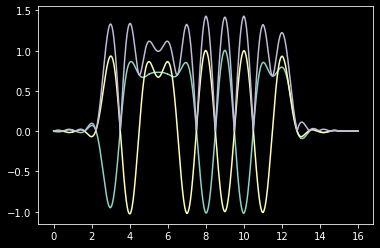

In [ ]:
plt.plot(t, qW.real)
plt.plot(t, qW.imag)
plt.plot(t, np.abs(qW))
#plt.xlim(1900,2200)

https://stackoverflow.com/questions/14614966/easy-way-to-implement-a-root-raised-cosine-rrc-filter-using-python-numpy

In [ ]:
qW.size, int(qW.size/A)

NameError: ignored

In [ ]:
!pip install APNG
from apng import APNG

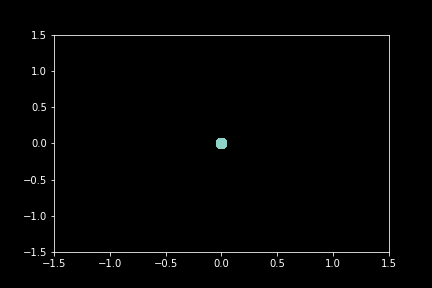

In [ ]:
files = []
A = 1000 # 間引き
for i in range(int(qW.size/A)):
  filename = "file%03d.png" % i
  fig = plt.figure()
  plt.scatter(qW.real[i*A:i*A+A], qW.imag[i*A:i*A+A], s=100)
  plt.xlim(-1.5,1.5)
  plt.ylim(-1.5,1.5)
  plt.savefig(filename)
  plt.close(fig)
  files.append(filename)
APNG.from_files(files, delay=int(1000*A/sampling_rate)).save("animation.png")
IPython.display.Image("animation.png")

In [ ]:
# 搬送波
A = 0.6
fc = 523 # (Hz) Carrier frequency
qW.size
y = A * np.real( np.exp( (1j) * 2 * np.pi * fc * t) * qW )

In [ ]:
IPython.display.Audio(y, rate = sampling_rate)

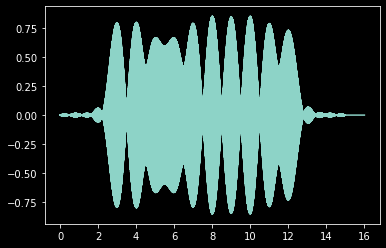

In [ ]:
plt.plot(t, y)

(2.8, 3.0)

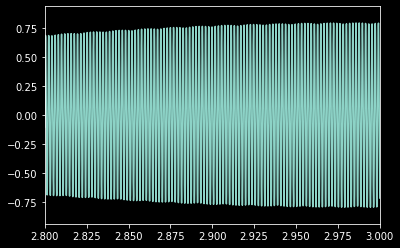

In [ ]:
plt.plot(t, y)
plt.xlim(2.8,3)

In [ ]:
# フーリエ変換，短時間フーリエ変換